In [2]:
%cd ..

/home/jovyan/3d-AAE


In [3]:
!pwd

/home/jovyan/3d-AAE


In [4]:
import numpy as np
from sklearn.manifold import TSNE
import argparse
import json
import logging
import random
from datetime import datetime
from importlib import import_module
from itertools import chain
from os.path import join, exists
import matplotlib.pyplot as plt
import torch
from torch.autograd import grad
import torch.backends.cudnn as cudnn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.utils.data import DataLoader

from utils.pcutil import plot_3d_point_cloud
from utils.util import find_latest_epoch, prepare_results_dir, cuda_setup, setup_logging

cudnn.benchmark = True
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering

# Copied from the other code

In [5]:
#%cd ..

In [6]:
import argparse
import json
import logging
import random
from datetime import datetime
from importlib import import_module
from itertools import chain
from os.path import join, exists
import matplotlib.pyplot as plt
import torch
from torch.autograd import grad
import torch.backends.cudnn as cudnn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.utils.data import DataLoader

from utils.pcutil import plot_3d_point_cloud
from utils.util import find_latest_epoch, prepare_results_dir, cuda_setup, setup_logging

cudnn.benchmark = True
import numpy as np

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname in ('Conv1d', 'Linear'):
        torch.nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)


In [8]:
with open('/home/jovyan/3d-AAE/settings/hyperparams.json') as f:
    config = json.load(f)

In [9]:
random.seed(config['seed'])
torch.manual_seed(config['seed'])
torch.cuda.manual_seed_all(config['seed'])

results_dir = prepare_results_dir(config)
starting_epoch = find_latest_epoch(results_dir) + 1

if not exists(join(results_dir, 'config.json')):
    with open(join(results_dir, 'config.json'), mode='w') as f:
        json.dump(config, f)

setup_logging(results_dir)
log = logging.getLogger(__name__)

device = cuda_setup(config['cuda'], config['gpu'])
log.debug(f'Device variable: {device}')
if device.type == 'cuda':
    log.debug(f'Current CUDA device: {torch.cuda.current_device()}')

weights_path = join(results_dir, 'weights')

2021-08-24 10:39:27,103: DEBUG    Device variable: cuda
2021-08-24 10:39:27,104: DEBUG    Current CUDA device: 0


In [10]:
#
# Dataset
#
dataset_name = config['dataset'].lower()
if dataset_name == 'shapenet':
    from datasets.shapenet import ShapeNetDataset
    dataset = ShapeNetDataset(root_dir=config['data_dir'],
                              classes=config['classes'])
elif dataset_name == 'faust':
    from datasets.dfaust import DFaustDataset
    dataset = DFaustDataset(root_dir=config['data_dir'],
                            classes=config['classes'])
else:
    raise ValueError(f'Invalid dataset name. Expected `shapenet` or '
                     f'`faust`. Got: `{dataset_name}`')
log.debug("Selected {} classes. Loaded {} samples.".format(
    'all' if not config['classes'] else ','.join(config['classes']),
    len(dataset)))

points_dataloader = DataLoader(dataset, batch_size=config['batch_size'],
                               shuffle=config['shuffle'],
                               num_workers=config['num_workers'],
                               drop_last=True, pin_memory=True)

2021-08-24 10:39:28,400: DEBUG    Selected all classes. Loaded 48809 samples.


In [11]:
#
# Models
#
arch = import_module(f"models.{config['arch']}")
G = arch.Generator(config).to(device)
E = arch.Encoder(config).to(device)
D = arch.Discriminator(config).to(device)

G.apply(weights_init)
E.apply(weights_init)
D.apply(weights_init)

if config['reconstruction_loss'].lower() == 'chamfer':
    from losses.champfer_loss import ChamferLoss
    reconstruction_loss = ChamferLoss().to(device)
elif config['reconstruction_loss'].lower() == 'earth_mover':
    from losses.earth_mover_distance import EMD
    reconstruction_loss = EMD().to(device)
else:
    raise ValueError(f'Invalid reconstruction loss. Accepted `chamfer` or '
                     f'`earth_mover`, got: {config["reconstruction_loss"]}')

In [12]:
#
# Float Tensors
#
fixed_noise = torch.FloatTensor(config['batch_size'], config['z_size'], 1)
fixed_noise.normal_(mean=config['normal_mu'], std=config['normal_std'])
noise = torch.FloatTensor(config['batch_size'], config['z_size'])

fixed_noise = fixed_noise.to(device)
noise = noise.to(device)

In [13]:
#
# Optimizers
#
EG_optim = getattr(optim, config['optimizer']['EG']['type'])
EG_optim = EG_optim(chain(E.parameters(), G.parameters()),
                    **config['optimizer']['EG']['hyperparams'])

D_optim = getattr(optim, config['optimizer']['D']['type'])
D_optim = D_optim(D.parameters(),
                  **config['optimizer']['D']['hyperparams'])

In [14]:
starting_epoch=1719
print(join(weights_path, f'{starting_epoch-1:05}_G.pth'))
E.load_state_dict(torch.load('/home/jovyan/3d-AAE/test-results/aae/experiment/weights/chair01720_E.pth'))
G.load_state_dict(torch.load('/home/jovyan/3d-AAE/test-results/aae/experiment/weights/chair01720_G.pth'))

/home/jovyan/3d-AAE/test-results/aae/experiment/weights/01718_G.pth


<All keys matched successfully>

In [15]:
# G.eval()
# E.eval()
# D.eval()

# codes_chair=[]
# # codes_all=[]
# # labels_all=[]

# with torch.no_grad():
#     for i, point_data in enumerate(points_dataloader, 1):
#         log.debug('-' * 20)
#         X, labels = point_data
#         #print(_)
#         X = X.to(device)
#         if X.size(-1) == 3:
#             X.transpose_(X.dim() - 2, X.dim() - 1)
    
#         codes, _, _ = E(X)
        
#         for j in range(50):
#             if labels[j]==17:
#                 codes_chair.append(list(codes[j].cpu().numpy()))
                
    
#         saving all latent objects 
#         for i in range(50):
#             if labels[i]==16 or labels[i]==21:
#                 codes_all.append(list(codes[i].cpu().numpy()))
#                 labels_all.append(labels[i])

                

In [15]:
a= np.asarray(codes_chair)
np.save('chair_latent.npy', a)

In [19]:
a= np.asarray(labels_all)
np.save('all_labels.npy', a)

# Experiments in the latent space

In [109]:
all_codes= np.load('all_latent.npy')
all_labels= np.load('all_labels.npy')

In [15]:
def plot_3d_point_cloud(x, y, z, show=True, show_axis=True, in_u_sphere=False,
                        marker='.', s=8, alpha=.8, figsize=(5, 5), elev=10,
                        azim=240, axis=None, title=None, *args, **kwargs):
    #plt.switch_backend('agg')
    
    if axis is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection='3d')
    else:
        ax = axis
        fig = axis

    if title is not None:
        plt.title(title)

    sc = ax.scatter(x, y, z, marker=marker, s=s, alpha=alpha, *args, **kwargs)
    ax.view_init(elev=elev, azim=azim)

    if in_u_sphere:
        ax.set_xlim3d(-0.5, 0.5)
        ax.set_ylim3d(-0.5, 0.5)
        ax.set_zlim3d(-0.5, 0.5)
    else:
        # Multiply with 0.7 to squeeze free-space.
        miv = 0.7 * np.min([np.min(x), np.min(y), np.min(z)])
        mav = 0.7 * np.max([np.max(x), np.max(y), np.max(z)])
        ax.set_xlim(miv, mav)
        ax.set_ylim(miv, mav)
        ax.set_zlim(miv, mav)
        plt.tight_layout()

    if not show_axis:
        plt.axis('off')

    if 'c' in kwargs:
        plt.colorbar(sc)

    if show:
        plt.show()

    return fig

In [16]:
def reconstruct_from_code(code):
    av=[]
    for i in range(50):
        av.append(code)
    av=np.reshape(av, (2048, 50)).T
    codes=torch.from_numpy(av).to("cuda")
    with torch.no_grad():
        X_rec = G(codes.float()).data.cpu().numpy()
    return X_rec[0]

In [110]:
all_codes.shape

(13600, 2048)

2021-08-16 19:35:38,593: DEBUG    Loaded backend agg version unknown.


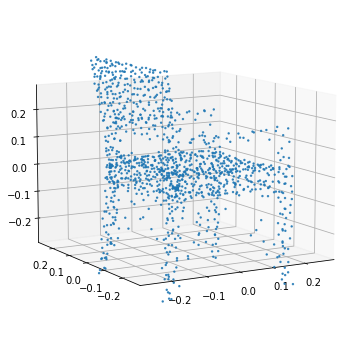

In [129]:
A=reconstruct_from_code(all_codes[10])
plot= plot_3d_point_cloud(A[0], A[1], A[2])

2021-08-16 19:35:28,867: DEBUG    Loaded backend agg version unknown.


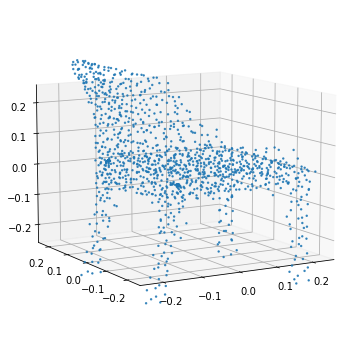

In [128]:
shuffle = np.copy(all_codes[10])
np.random.shuffle(shuffle)
B=reconstruct_from_code(shuffle)
plot= plot_3d_point_cloud(B[0], B[1], B[2])

PCA and T-SNE plots for the latent space

In [15]:
car_codes= np.load('car_latent.npy')

In [29]:
car_codes.shape

(6370, 2048)

In [19]:
#X_embedded = TSNE(n_components=2).fit_transform(car_codes.T)

In [33]:
X_embedded= np.load('car_feature_tsne.npy')

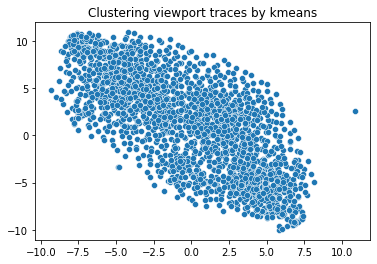

In [26]:
palette = sns.color_palette("bright", 24)
plt.figure()
plt.title('Clustering viewport traces by kmeans')
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], legend='full', palette=palette)
plt.show()

Clustering in the latent space

In [27]:
from sklearn.cluster import KMeans
n=24
kmeans = KMeans(n_clusters=n, random_state=0).fit(car_codes.T)
a=kmeans.labels_

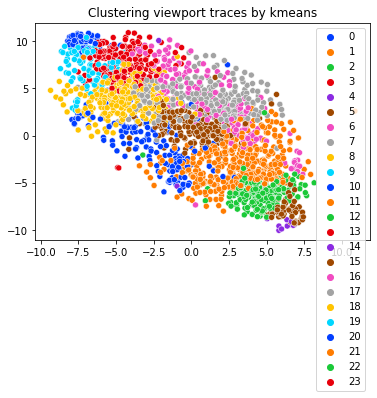

In [28]:
palette = sns.color_palette("bright", 24)
plt.figure()
plt.title('Clustering viewport traces by kmeans')
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue= a, legend='full', palette=palette)
plt.show()

In [34]:
from sklearn.cluster import KMeans
n=5
kmeans = KMeans(n_clusters=n, random_state=0).fit(car_codes.T)
a=kmeans.labels_

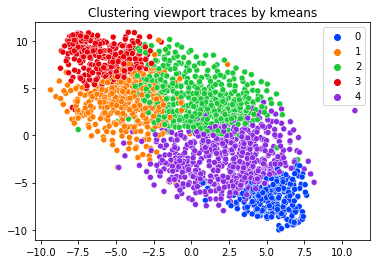

In [35]:
palette = sns.color_palette("bright", 5)
plt.figure()
plt.title('Clustering viewport traces by kmeans')
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue= a, legend='full', palette=palette)
plt.show()

feature removal and reconstruction

In [17]:
def plot_3d_point_cloud_dual(x1,y1,z1,x2,y2,z2, marker='.', s=8, alpha=.8, figsize=(10, 10), elev=10,
                        azim=240, axis=None, title=None):
    #plt.switch_backend('agg')
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(121, projection='3d')

    sc = ax.scatter(x1, y1, z1, marker=marker, s=s, alpha=alpha)
    ax.view_init(elev=elev, azim=azim)

    miv = 0.7 * np.min([np.min(x1), np.min(y1), np.min(z1)])
    mav = 0.7 * np.max([np.max(x1), np.max(y1), np.max(z1)])
    ax.set_xlim(miv, mav)
    ax.set_ylim(miv, mav)
    ax.set_zlim(miv, mav)
    
    ax2 = fig.add_subplot(122, projection='3d')

    sc = ax2.scatter(x2, y2, z2, marker=marker, s=s, alpha=alpha)
    ax2.view_init(elev=elev, azim=azim)

    miv = 0.7 * np.min([np.min(x2), np.min(y2), np.min(z2)])
    mav = 0.7 * np.max([np.max(x2), np.max(y2), np.max(z2)])
    ax2.set_xlim(miv, mav)
    ax2.set_ylim(miv, mav)
    ax2.set_zlim(miv, mav)
    
    
    plt.tight_layout()
    plt.show(fig)
    
def plot_3d_point_cloud_dual_shaded(all0,all1):
    
    fig = plt.figure(figsize=(12,4))
    
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    #ax = fig.gca(projection='3d')
    pt= np.asarray(all0)
    x = pt[0]
    y = pt[1]
    z = pt[2]
    c = np.sqrt((x-9)**2 + (y+25)**2)# + (z-1.8)**2) # think later
    ax.scatter(x, y, z, c=-c, cmap='Blues', s=50, marker='o', edgecolors='black', linewidths=0.015)
    max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max()
    Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(x.max()+x.min())
    Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(y.max()+y.min())
    Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(z.max()+z.min())
    # Comment or uncomment following both lines to test the fake bounding box:
    for xb, yb, zb in zip(Xb, Yb, Zb):
        ax.plot([xb], [yb], [zb], 'w')
    #ax.view_init(elev=20, azim=120)
    ax.set_axis_off()
    
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    #ax = fig.gca(projection='3d')
    pt= np.asarray(all1)
    x = pt[0]
    y = pt[1]
    z = pt[2]
    c = np.sqrt((x-9)**2 + (y+25)**2)# + (z-1.8)**2) # think later
    ax2.scatter(x, y, z, c=-c, cmap='Blues', s=50, marker='o', edgecolors='black', linewidths=0.015)
    max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max()
    Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(x.max()+x.min())
    Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(y.max()+y.min())
    Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(z.max()+z.min())
    # Comment or uncomment following both lines to test the fake bounding box:
    for xb, yb, zb in zip(Xb, Yb, Zb):
        ax2.plot([xb], [yb], [zb], 'w')
    #ax.view_init(elev=20, azim=120)
    ax2.set_axis_off()
    
    
    fig.tight_layout()
    plt.grid()
    plt.show()
    
def plot_3d_point_cloud_triple_shaded(all0,all1,all2):
    
    fig = plt.figure(figsize=(18,4))
    
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    #ax = fig.gca(projection='3d')
    pt= np.asarray(all0)
    x = pt[0]
    y = pt[1]
    z = pt[2]
    c = np.sqrt((x-9)**2 + (y+25)**2)# + (z-1.8)**2) # think later
    ax.scatter(x, y, z, c=-c, cmap='Blues', s=50, marker='o', edgecolors='black', linewidths=0.015)
    max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max()
    Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(x.max()+x.min())
    Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(y.max()+y.min())
    Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(z.max()+z.min())
    # Comment or uncomment following both lines to test the fake bounding box:
    for xb, yb, zb in zip(Xb, Yb, Zb):
        ax.plot([xb], [yb], [zb], 'w')
    #ax.view_init(elev=20, azim=120)
    ax.set_axis_off()
    
    ax2 = fig.add_subplot(1, 3, 2, projection='3d')
    #ax = fig.gca(projection='3d')
    pt= np.asarray(all1)
    x = pt[0]
    y = pt[1]
    z = pt[2]
    c = np.sqrt((x-9)**2 + (y+25)**2)# + (z-1.8)**2) # think later
    ax2.scatter(x, y, z, c=-c, cmap='Blues', s=50, marker='o', edgecolors='black', linewidths=0.015)
    max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max()
    Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(x.max()+x.min())
    Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(y.max()+y.min())
    Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(z.max()+z.min())
    # Comment or uncomment following both lines to test the fake bounding box:
    for xb, yb, zb in zip(Xb, Yb, Zb):
        ax2.plot([xb], [yb], [zb], 'w')
    #ax.view_init(elev=20, azim=120)
    ax2.set_axis_off()
    
    
    ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    #ax = fig.gca(projection='3d')
    pt= np.asarray(all2)
    x = pt[0]
    y = pt[1]
    z = pt[2]
    c = np.sqrt((x-9)**2 + (y+25)**2)# + (z-1.8)**2) # think later
    ax3.scatter(x, y, z, c=-c, cmap='Blues', s=50, marker='o', edgecolors='black', linewidths=0.015)
    max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max()
    Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(x.max()+x.min())
    Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(y.max()+y.min())
    Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(z.max()+z.min())
    # Comment or uncomment following both lines to test the fake bounding box:
    for xb, yb, zb in zip(Xb, Yb, Zb):
        ax3.plot([xb], [yb], [zb], 'w')
    #ax.view_init(elev=20, azim=120)
    ax3.set_axis_off()
    
    
    fig.tight_layout()
    plt.grid()
    plt.show()


In [18]:
def plot_many_objects(nrows, ncolumns, objs):
    
    fig = plt.figure(figsize=(6*ncolumns,4*nrows))
    
    for i in range(len(objs)):
        ax = fig.add_subplot(nrows, ncolumns, i+1, projection='3d')
        #ax = fig.gca(projection='3d')
        pt= np.asarray(objs[i])
        x = pt[0]
        y = pt[1]
        z = pt[2]
        c = np.sqrt((x-9)**2 + (y+25)**2)# + (z-1.8)**2) # think later
        ax.scatter(x, y, z, c=-c, cmap='Blues', s=50, marker='o', edgecolors='black', linewidths=0.015)
        max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max()
        Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(x.max()+x.min())
        Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(y.max()+y.min())
        Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(z.max()+z.min())
        # Comment or uncomment following both lines to test the fake bounding box:
        for xb, yb, zb in zip(Xb, Yb, Zb):
            ax.plot([xb], [yb], [zb], 'w')
        #ax.view_init(elev=20, azim=120)
        ax.set_axis_off()
    
    fig.tight_layout()
    plt.grid()
    plt.show()

In [19]:
def reconstruct_from_code(code):
    av=[]
    for i in range(50):
        av.append(code)
    av=np.reshape(av, (2048, 50)).T
    codes=torch.from_numpy(av).to("cuda")
    
    with torch.no_grad():
        X_rec = G(codes).data.cpu().numpy()
    #print(X_rec[30]==X_rec[10])
    return X_rec[0]

Experiments for chair class

In [20]:
def plot_pc_shaded(all0,i=0):
    pt= np.asarray(all0)
    # ax = fig.add_subplot(1, 1, 1, projection='3d')
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    #ax = fig.gca(projection='3d')
    x = pt[0]
    y = pt[1]
    z = pt[2]
    c = np.sqrt((x-9)**2 + (y+25)**2)# + (z-1.8)**2) # think later

    ax.scatter(x, y, z, c=-c, cmap='Blues', s=50, marker='o', edgecolors='black', linewidths=0.015)

    max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max()
    Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(x.max()+x.min())
    Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(y.max()+y.min())
    Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(z.max()+z.min())
    # Comment or uncomment following both lines to test the fake bounding box:
    for xb, yb, zb in zip(Xb, Yb, Zb):
        ax.plot([xb], [yb], [zb], 'w')
    #ax.view_init(elev=20, azim=120)
    ax.set_axis_off()
    fig.tight_layout()
    plt.grid()
    #plt.savefig('/content/drive/MyDrive/MR-privacy/Data/plots/'+str(i)+'.png')
    plt.show()

In [21]:
chair_latent= np.load('chair_latent.npy')

In [35]:
chair_latent.shape

(5759, 2048)

In [95]:
# X_embedded = TSNE(n_components=2).fit_transform(chair_latent)
# np.save('chairs_tsne.npy', X_embedded)
# X_embedded = TSNE(n_components=2).fit_transform(chair_latent.T)
# np.save('chair_features_tsne.npy', X_embedded)

In [96]:
chairs_tsne=np.load('chairs_tsne.npy')
chair_features_tsne=np.load('chair_features_tsne.npy')

Plotting chairs in tsne

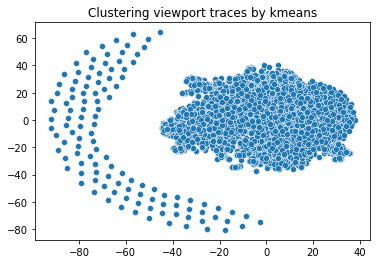

In [26]:
palette = sns.color_palette("bright", 24)
plt.figure()
plt.title('Clustering viewport traces by kmeans')
sns.scatterplot(x=chairs_tsne[:,0], y=chairs_tsne[:,1], legend='full', palette=palette)
plt.show()

In [29]:
clustering = AgglomerativeClustering(n_clusters=2, linkage='single').fit(chairs_tsne)
a=clustering.labels_

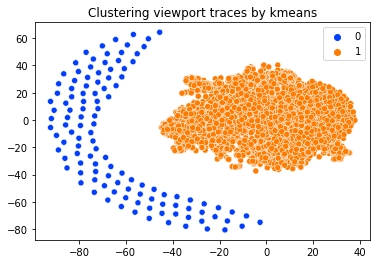

In [30]:
palette = sns.color_palette("bright", 2)
plt.figure()
plt.title('Clustering viewport traces by kmeans')
sns.scatterplot(x=chairs_tsne[:,0], y=chairs_tsne[:,1], hue= a, legend='full', palette=palette)
plt.show()

2412
(3, 2048)
5534
(3, 2048)
5475
(3, 2048)
4470
(3, 2048)
3169
(3, 2048)
2768
(3, 2048)
475
(3, 2048)
4445
(3, 2048)
4713
(3, 2048)
992
(3, 2048)


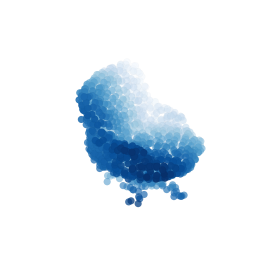

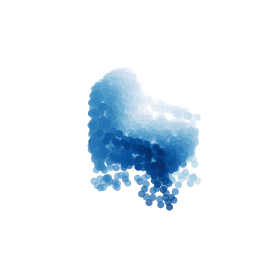

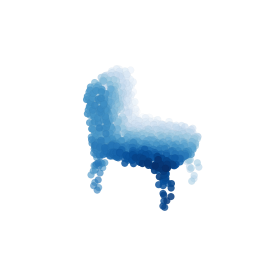

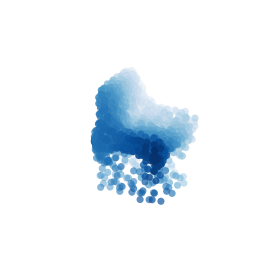

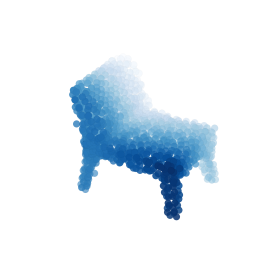

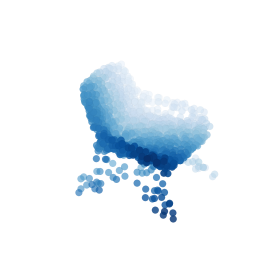

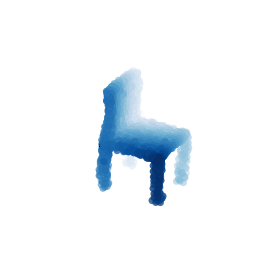

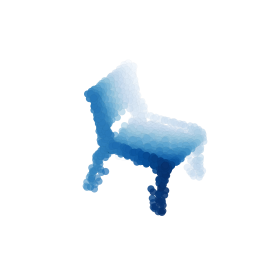

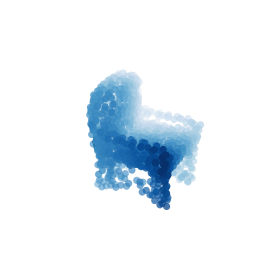

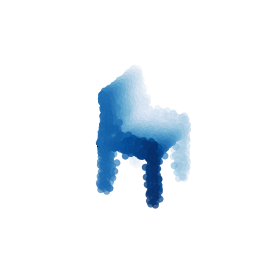

In [170]:
for i in range(10):
    q= np.random.randint(5700)
    print(q)
    if a[q]==1:
        A=reconstruct_from_code(chair_latent[q])
        print(A.shape)
        plot_pc_shaded(A)

5527
2928
3133
1165
604
5321
371
904
4902
4918
1797


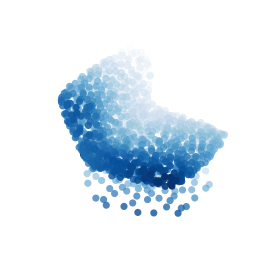

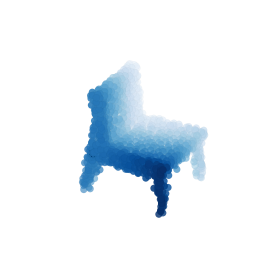

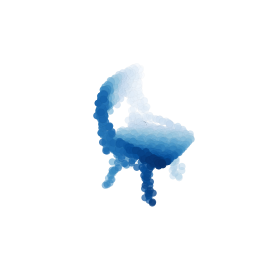

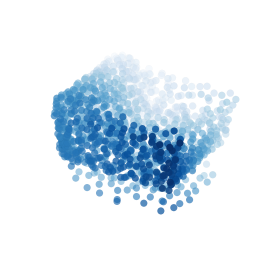

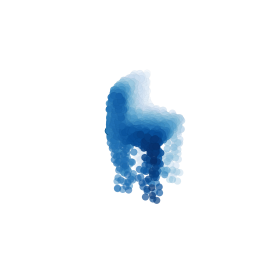

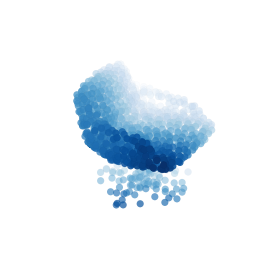

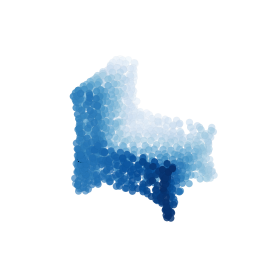

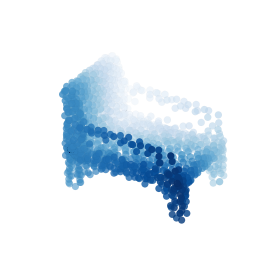

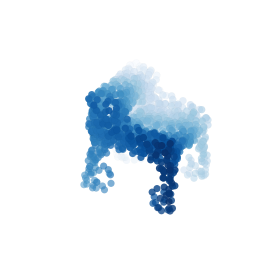

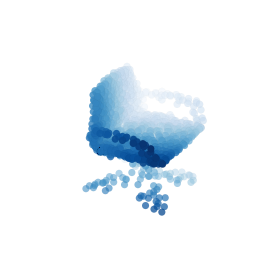

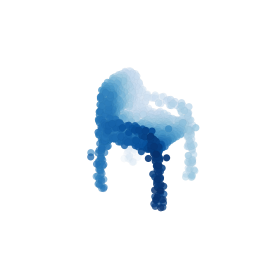

In [174]:
for i in range(1000):
    q= np.random.randint(5700)
    if a[q]==0:
        A=reconstruct_from_code(chair_latent[q])
        print(q)
        plot_pc_shaded(A)

Plotting chairs in tsne

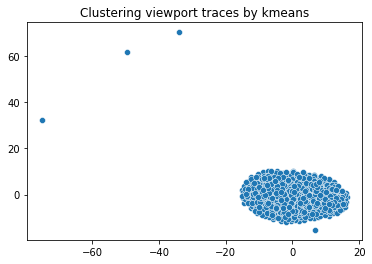

In [39]:
palette = sns.color_palette("bright", 24)
plt.figure()
plt.title('Clustering viewport traces by kmeans')
sns.scatterplot(x=chair_features_tsne[:,0], y=chair_features_tsne[:,1], legend='full', palette=palette)
plt.show()

Clustering in the latent space

In [97]:
from sklearn.cluster import KMeans
n=2
kmeans = KMeans(n_clusters=n, random_state=0).fit(chair_features_tsne)
a=kmeans.labels_

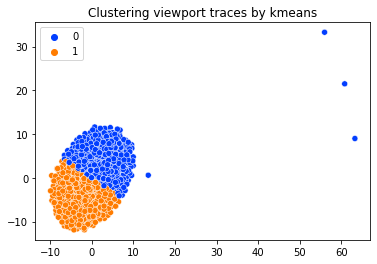

In [98]:
palette = sns.color_palette("bright", 2)
plt.figure()
plt.title('Clustering viewport traces by kmeans')
sns.scatterplot(x=chair_features_tsne[:,0], y=chair_features_tsne[:,1], hue= a, legend='full', palette=palette)
plt.show()

[-0.10330543 -0.16024049  0.12159137 ...  0.02682085 -0.20397988
 -0.13526362] [-0.10330543  0.          0.         ...  0.         -0.20397988
 -0.13526362]
True


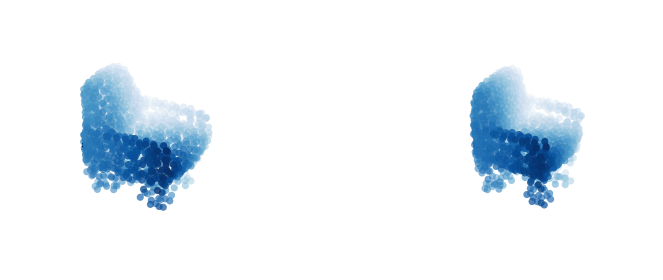

[ 0.04862569  0.13697897  0.01307281 ...  0.0524034   0.07298414
 -0.256306  ] [ 0.04862569  0.          0.         ...  0.          0.07298414
 -0.256306  ]
True


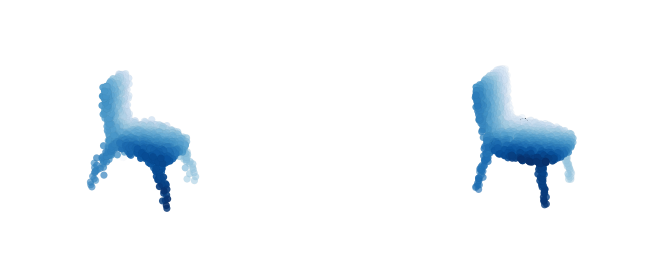

[-0.57968575 -0.21772495  0.07186387 ...  0.08666224 -0.05329425
 -0.03729536] [-0.57968575  0.          0.         ...  0.         -0.05329425
 -0.03729536]
True


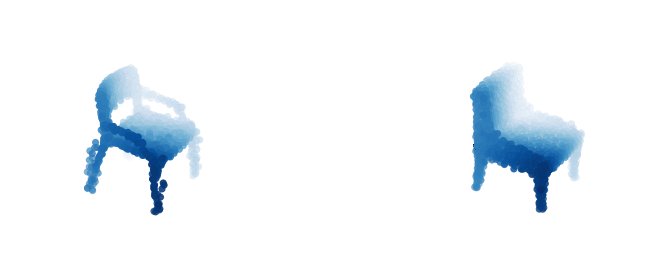

[-0.05461261  0.06188298  0.13833164 ...  0.0458634   0.10659347
 -0.17374617] [-0.05461261  0.          0.         ...  0.          0.10659347
 -0.17374617]
True


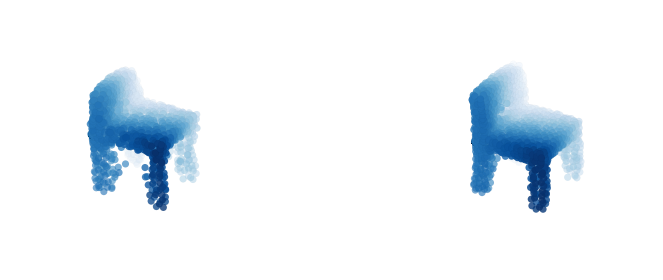

[-0.00783679  0.38383624  0.09911976 ... -0.096147   -0.38277942
 -0.26795787] [-0.00783679  0.          0.         ...  0.         -0.38277942
 -0.26795787]
True


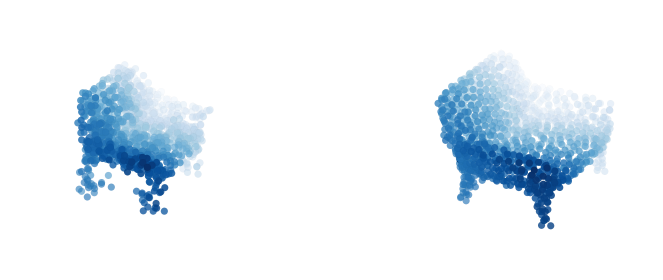

[ 0.01548777  0.1498019   0.07924856 ...  0.03066836 -0.20220622
 -0.18735352] [ 0.01548777  0.          0.         ...  0.         -0.20220622
 -0.18735352]
True


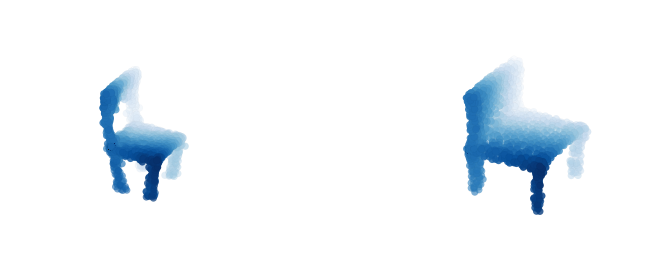

[-0.23517813 -0.20392212  0.4425578  ...  0.11785468  0.01724673
 -0.23883012] [-0.23517813  0.          0.         ...  0.          0.01724673
 -0.23883012]
True


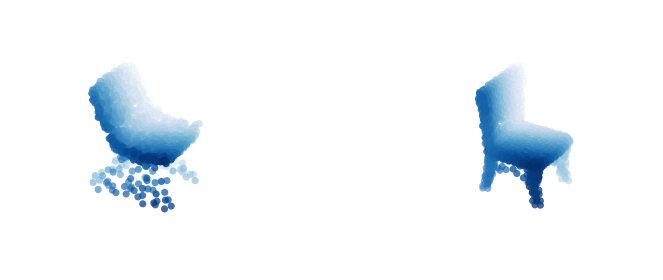

[ 0.03413351  0.00828712  0.19640172 ...  0.14834912 -0.18815224
 -0.05502864] [ 0.03413351  0.          0.         ...  0.         -0.18815224
 -0.05502864]
True


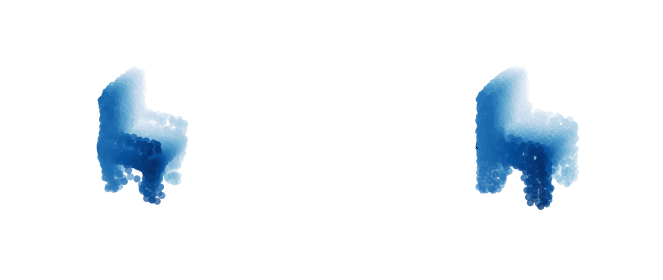

[-0.09603797  0.01529783  0.3221826  ...  0.09311517 -0.03035475
 -0.06310806] [-0.09603797  0.          0.         ...  0.         -0.03035475
 -0.06310806]
True


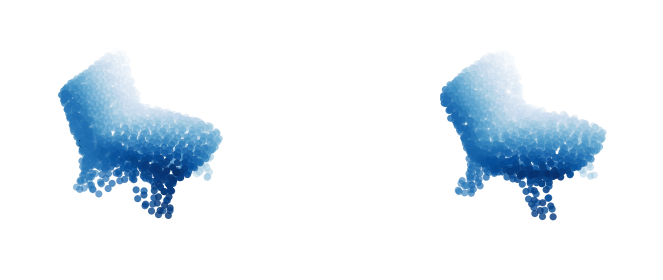

[-0.17055653  0.10350107  0.1950589  ...  0.19324163 -0.06422967
 -0.15913302] [-0.17055653  0.          0.         ...  0.         -0.06422967
 -0.15913302]
True


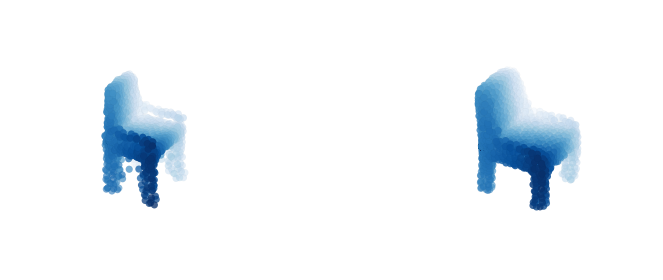

In [99]:
rem=1
for j in range(10):
    obj=10*j
    code1= chair_latent[obj].copy()
    code2= chair_latent[obj].copy()
    for i in range(2048):
        if a[i] == rem:
            #print('.')
            code2[i]=0
    print(code1,code2)
    print(0 in code2)
    A= reconstruct_from_code(code1)
    B= reconstruct_from_code(code2)
    plot_3d_point_cloud_dual_shaded(A,B)

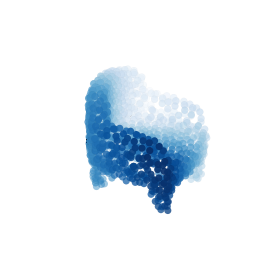

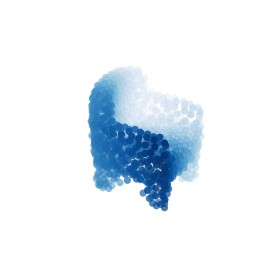

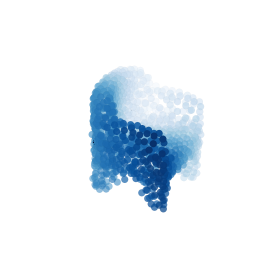

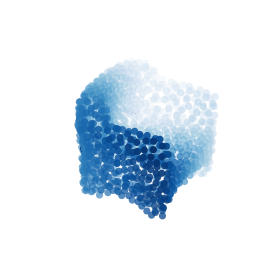

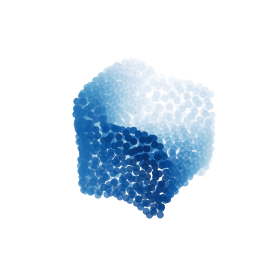

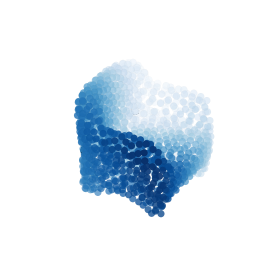

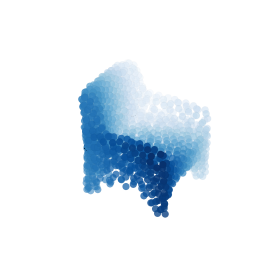

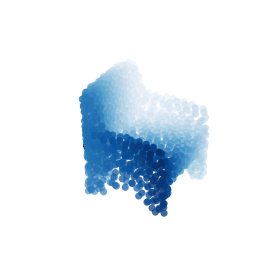

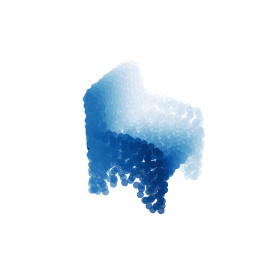

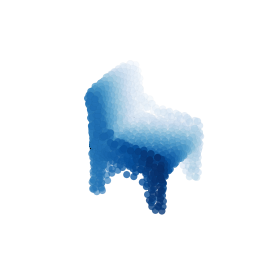

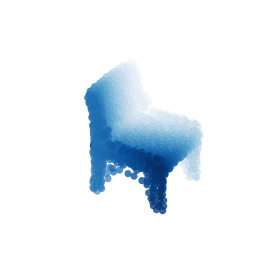

In [41]:
code2=chair_latent[3000].copy()
for i in range(10):
    code2[i*200:(i+1)*200]=[0]*200
    B= reconstruct_from_code(code2)
    plot_pc_shaded(B)
code2[:]=[0]*2048
B= reconstruct_from_code(code2)
plot_pc_shaded(B)

Latent space arithmetics

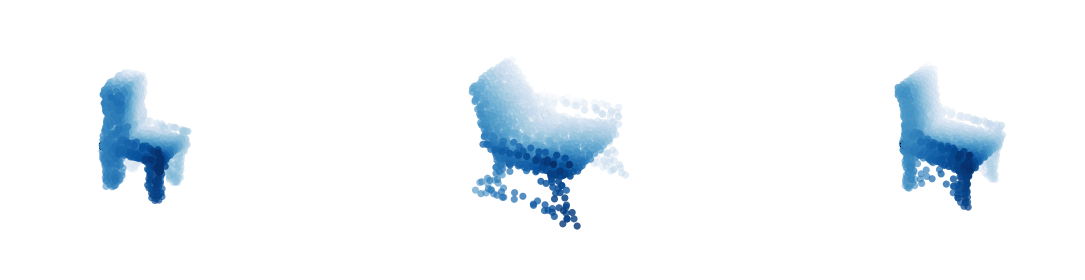

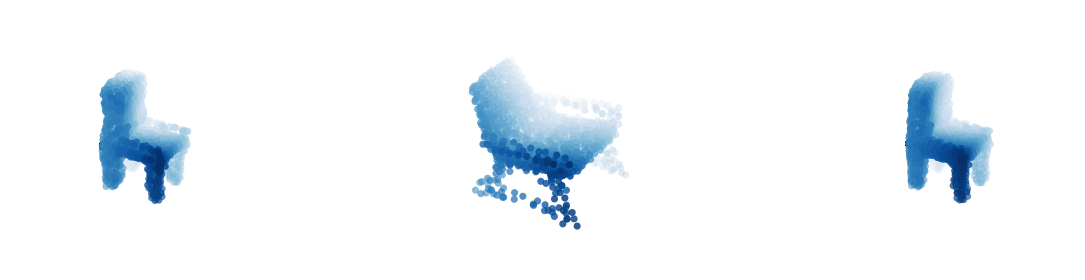

*******************************************************


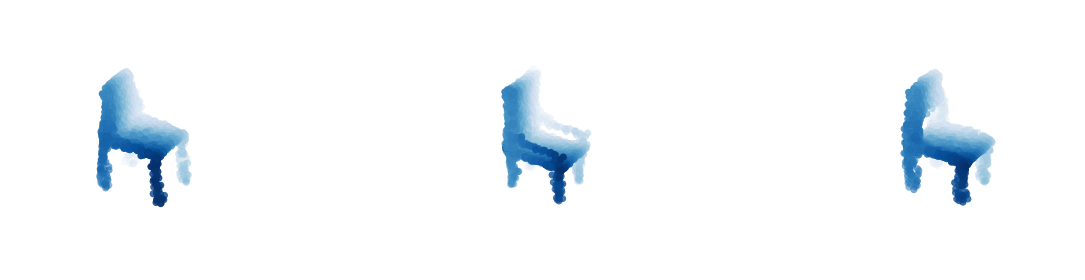

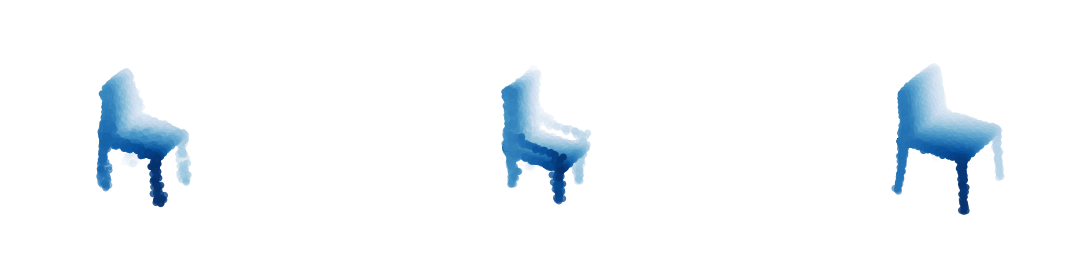

*******************************************************


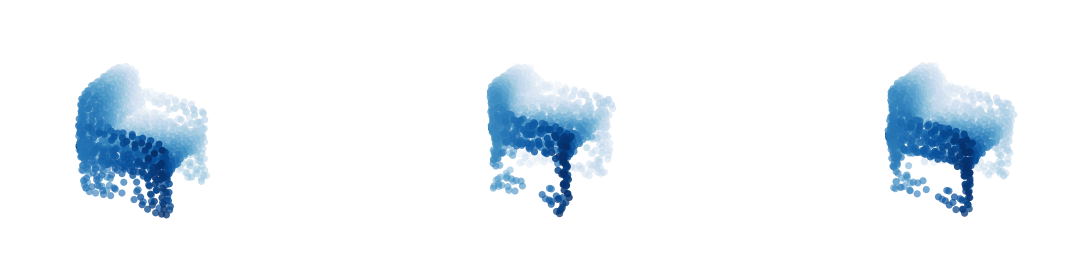

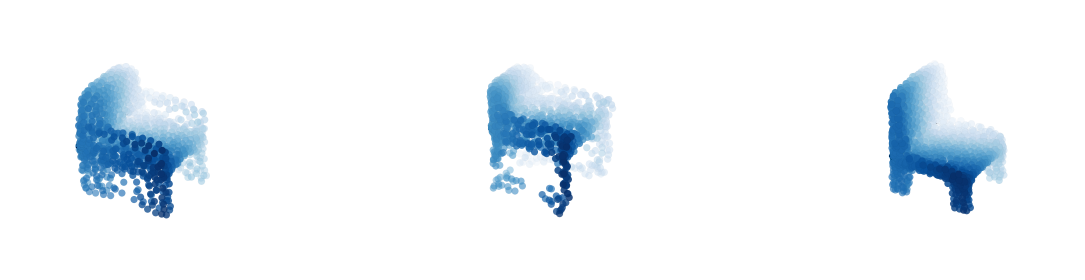

*******************************************************


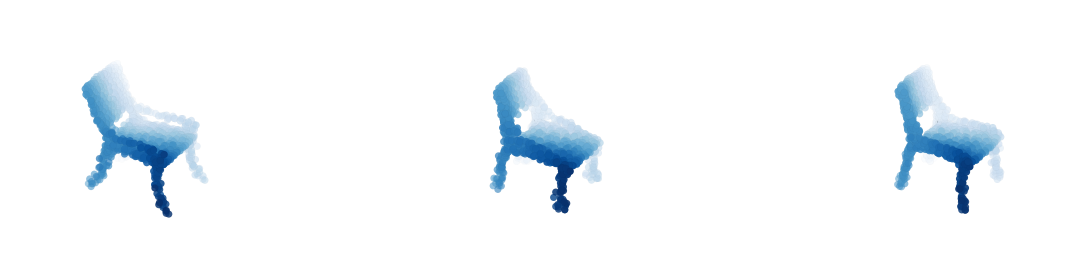

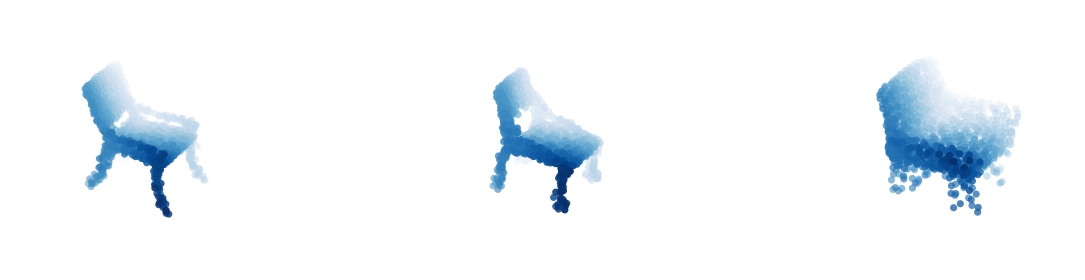

*******************************************************


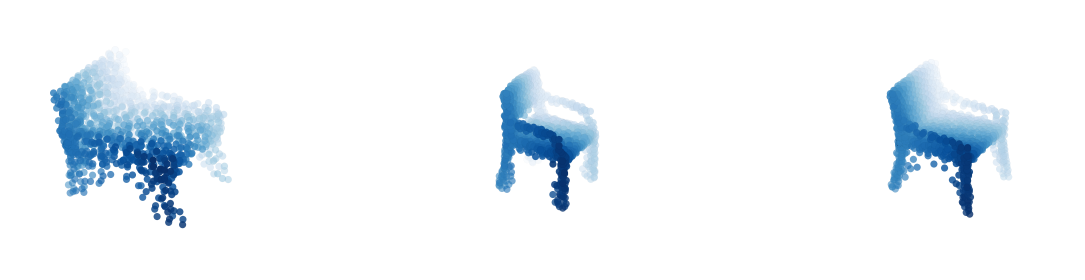

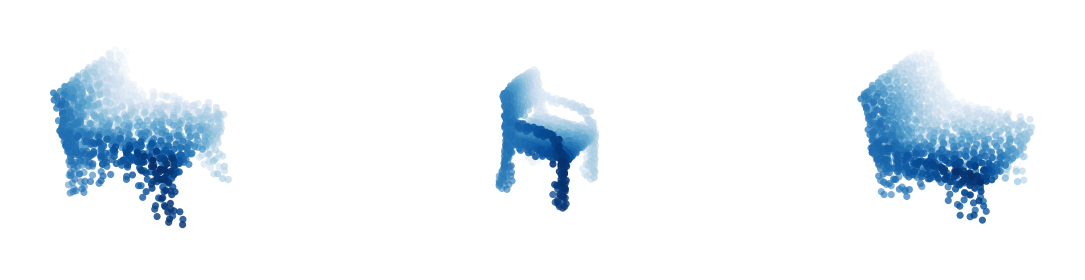

*******************************************************


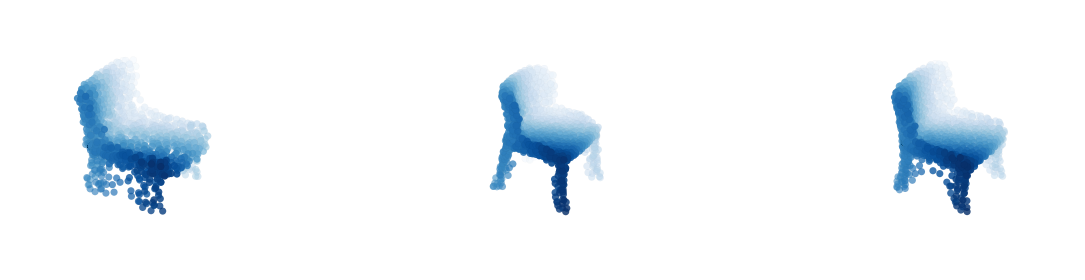

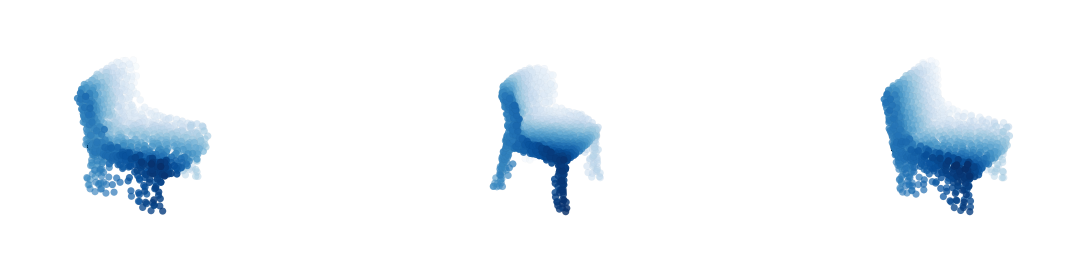

*******************************************************


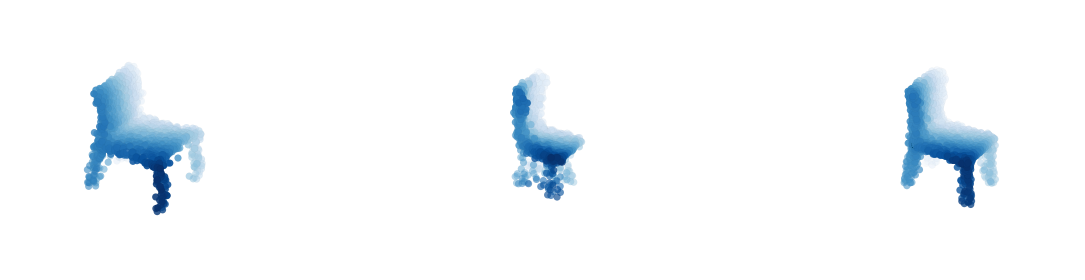

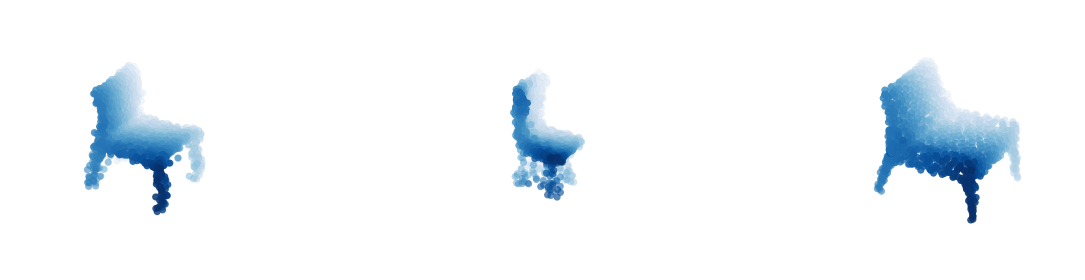

*******************************************************


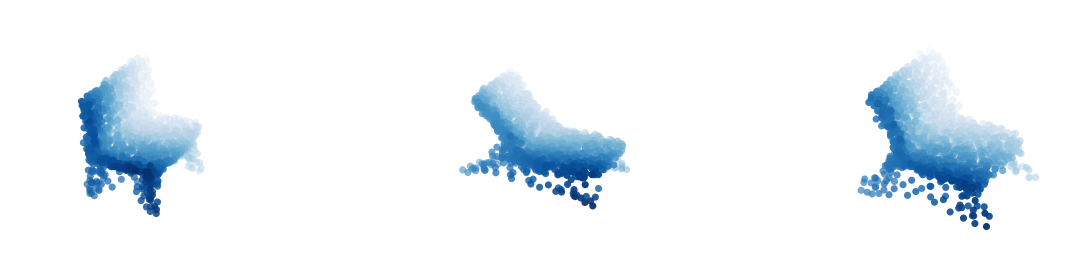

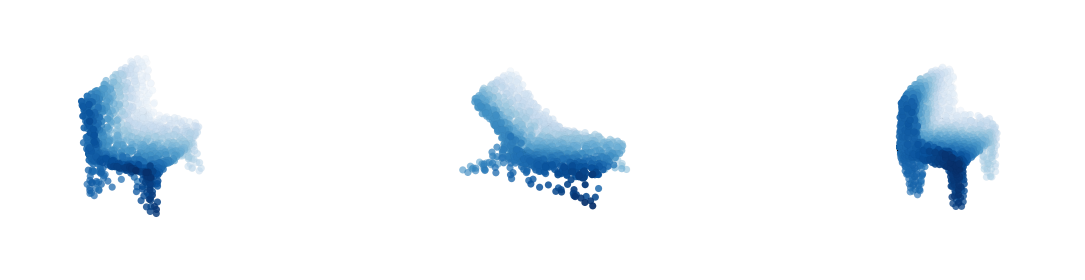

*******************************************************


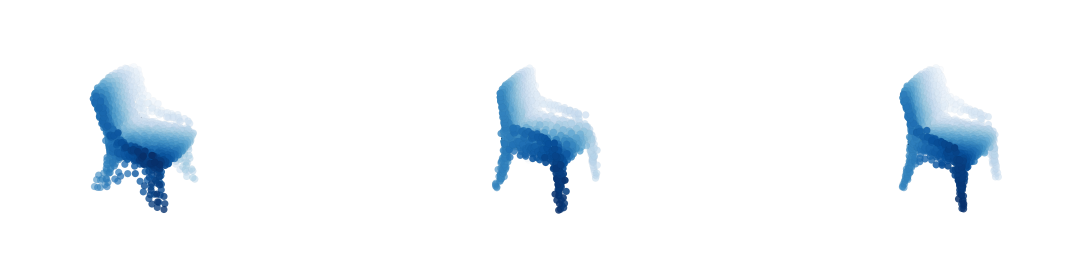

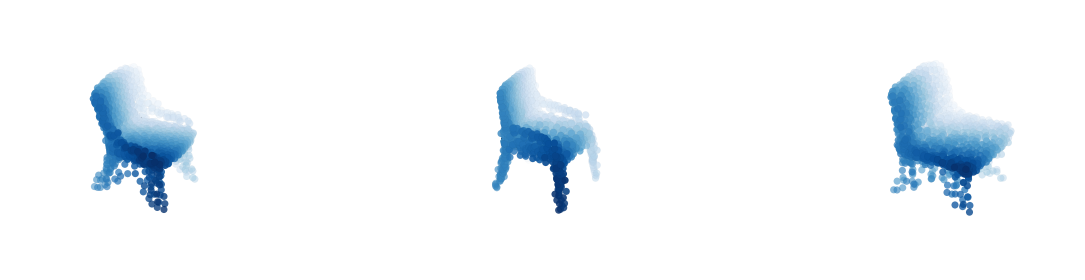

*******************************************************


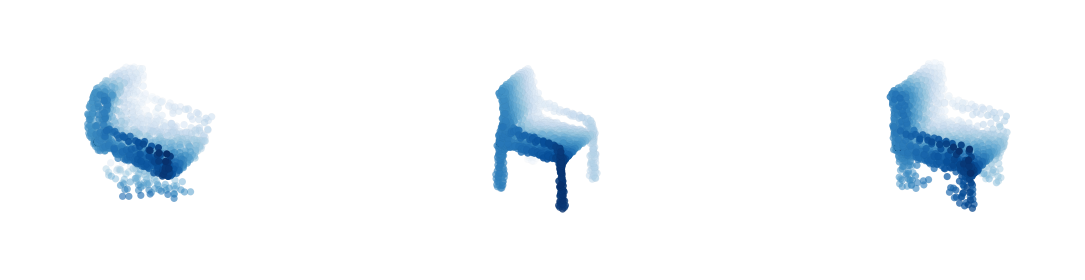

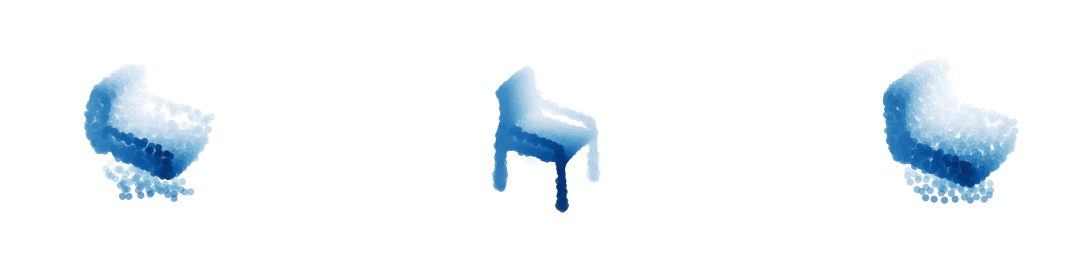

*******************************************************


In [40]:
for i in range(10):
    c1= np.random.randint(5700)
    c2= np.random.randint(5700)
    rec1= reconstruct_from_code(chair_latent[c1])
    rec2= reconstruct_from_code(chair_latent[c2])
    recadd= reconstruct_from_code((chair_latent[c1]+chair_latent[c2])/2)
    plot_3d_point_cloud_triple_shaded(rec1,rec2,recadd)
    recadd= reconstruct_from_code((chair_latent[c1]-chair_latent[c2])/2)
    plot_3d_point_cloud_triple_shaded(rec1,rec2,recadd)
    print('*******************************************************')

Comparing latent space with a GAN

In [52]:
#Fitting the latent space to normal distributions
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

mus, stds=[], []
for i in range(2048):
    mu, std = norm.fit(chair_latent.T[i])
    mus.append(mu)
    stds.append(std)
    
print(np.mean(mus), np.mean(stds))

0.0018441369 0.16996142


((array([  1.,   1.,   0.,   2.,   1.,   4.,   5.,   7.,  12.,  26.,  39.,
          45.,  69.,  69.,  88., 123., 111., 134., 149., 161., 163., 120.,
         132., 125., 122.,  73.,  79.,  68.,  48.,  31.,  19.,   8.,   4.,
           2.,   1.,   0.,   3.,   0.,   0.,   3.]),
  array([-0.18607154, -0.1766038 , -0.16713604, -0.15766829, -0.14820053,
         -0.13873278, -0.12926503, -0.11979727, -0.11032952, -0.10086177,
         -0.09139401, -0.08192626, -0.07245851, -0.06299075, -0.053523  ,
         -0.04405525, -0.0345875 , -0.02511974, -0.01565199, -0.00618424,
          0.00328352,  0.01275127,  0.02221902,  0.03168678,  0.04115453,
          0.05062228,  0.06009004,  0.06955779,  0.07902554,  0.0884933 ,
          0.09796105,  0.1074288 ,  0.11689655,  0.1263643 ,  0.13583206,
          0.1452998 ,  0.15476756,  0.16423532,  0.17370307,  0.18317083,
          0.19263858], dtype=float32),
  <BarContainer object of 40 artists>),
 (array([ 30., 371., 885., 451., 130.,  81.,  38., 

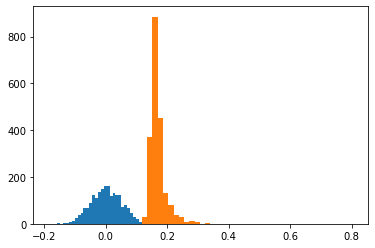

In [53]:
plt.hist(mus,40), plt.hist(stds,40)

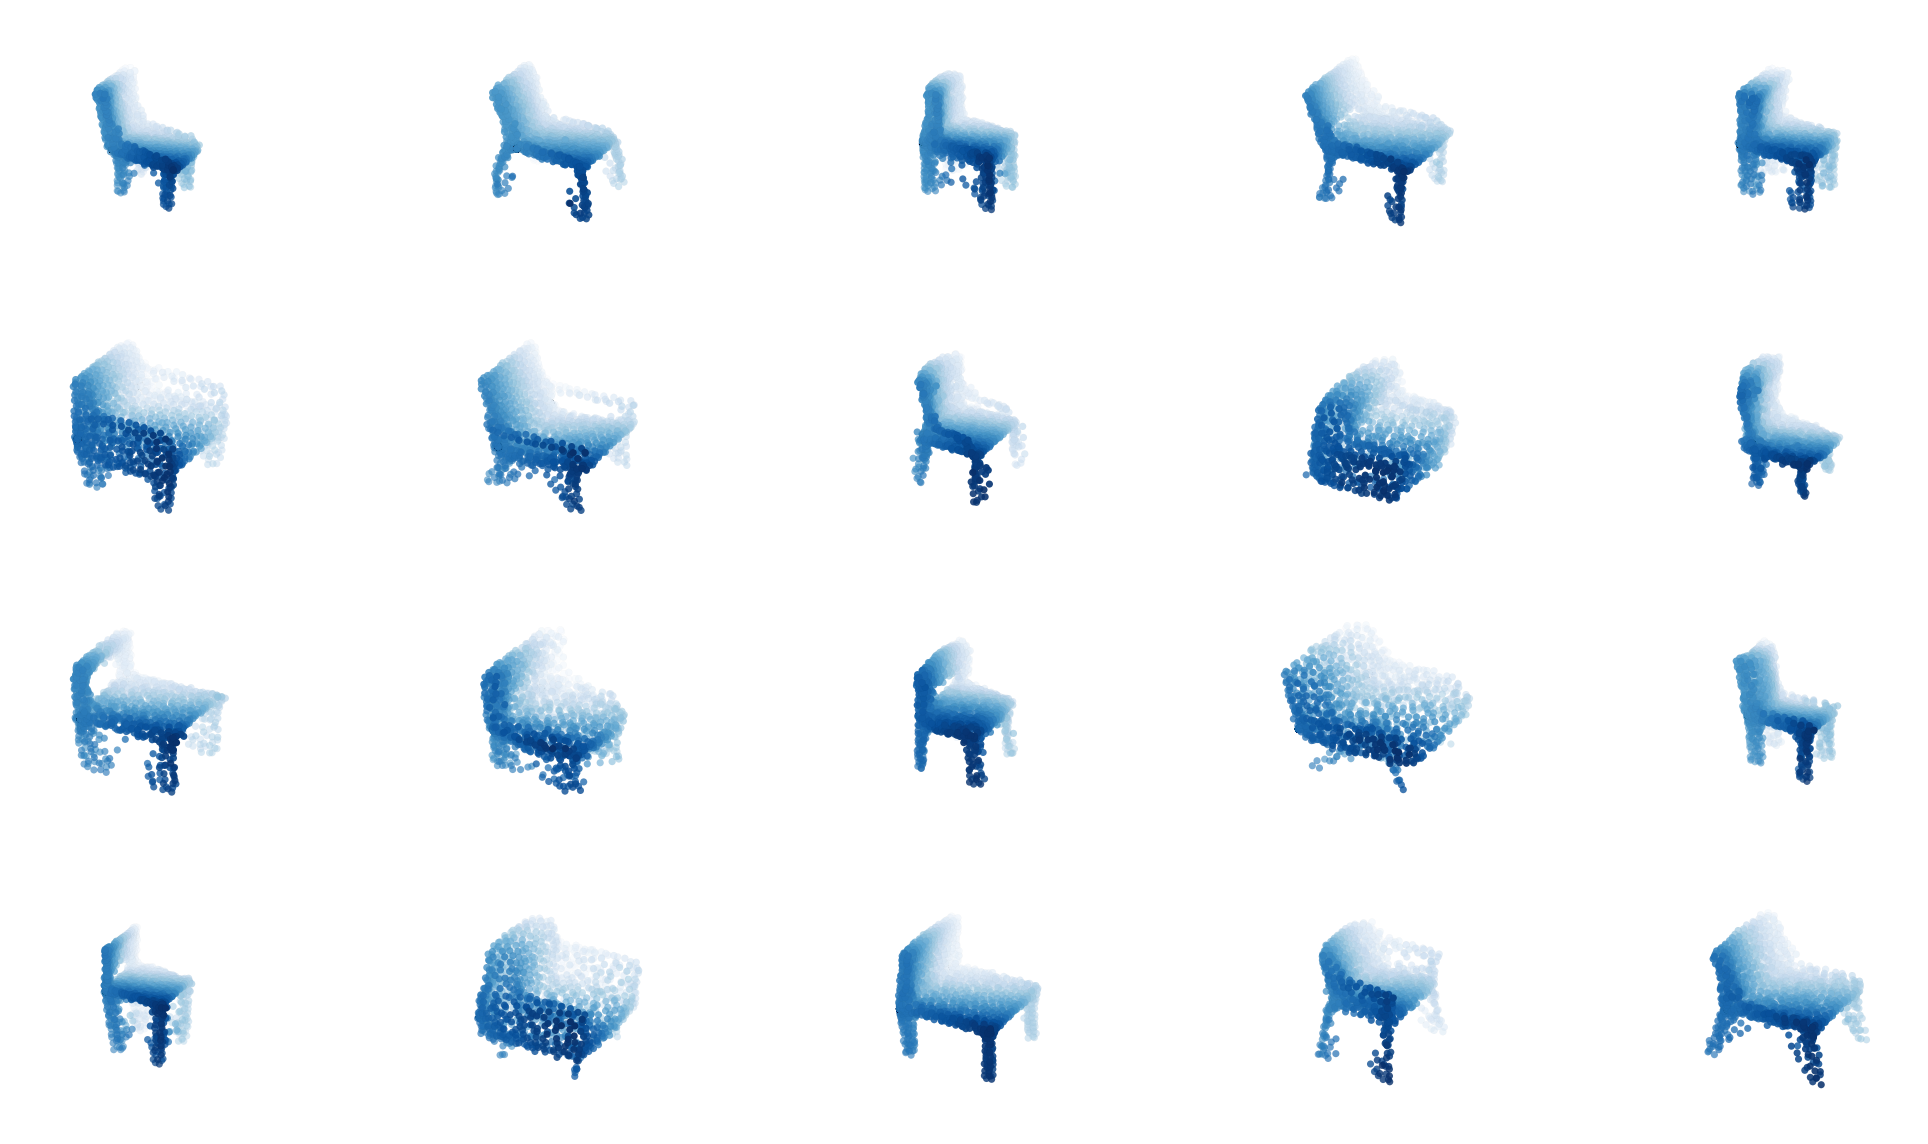

In [110]:
objs=[]
for i in range(20):
    noise= np.random.normal(0, 0.18, 2048)
    noise.astype(float)
    A=reconstruct_from_code(noise)
    objs.append(A)
plot_many_objects(4, 5, objs)

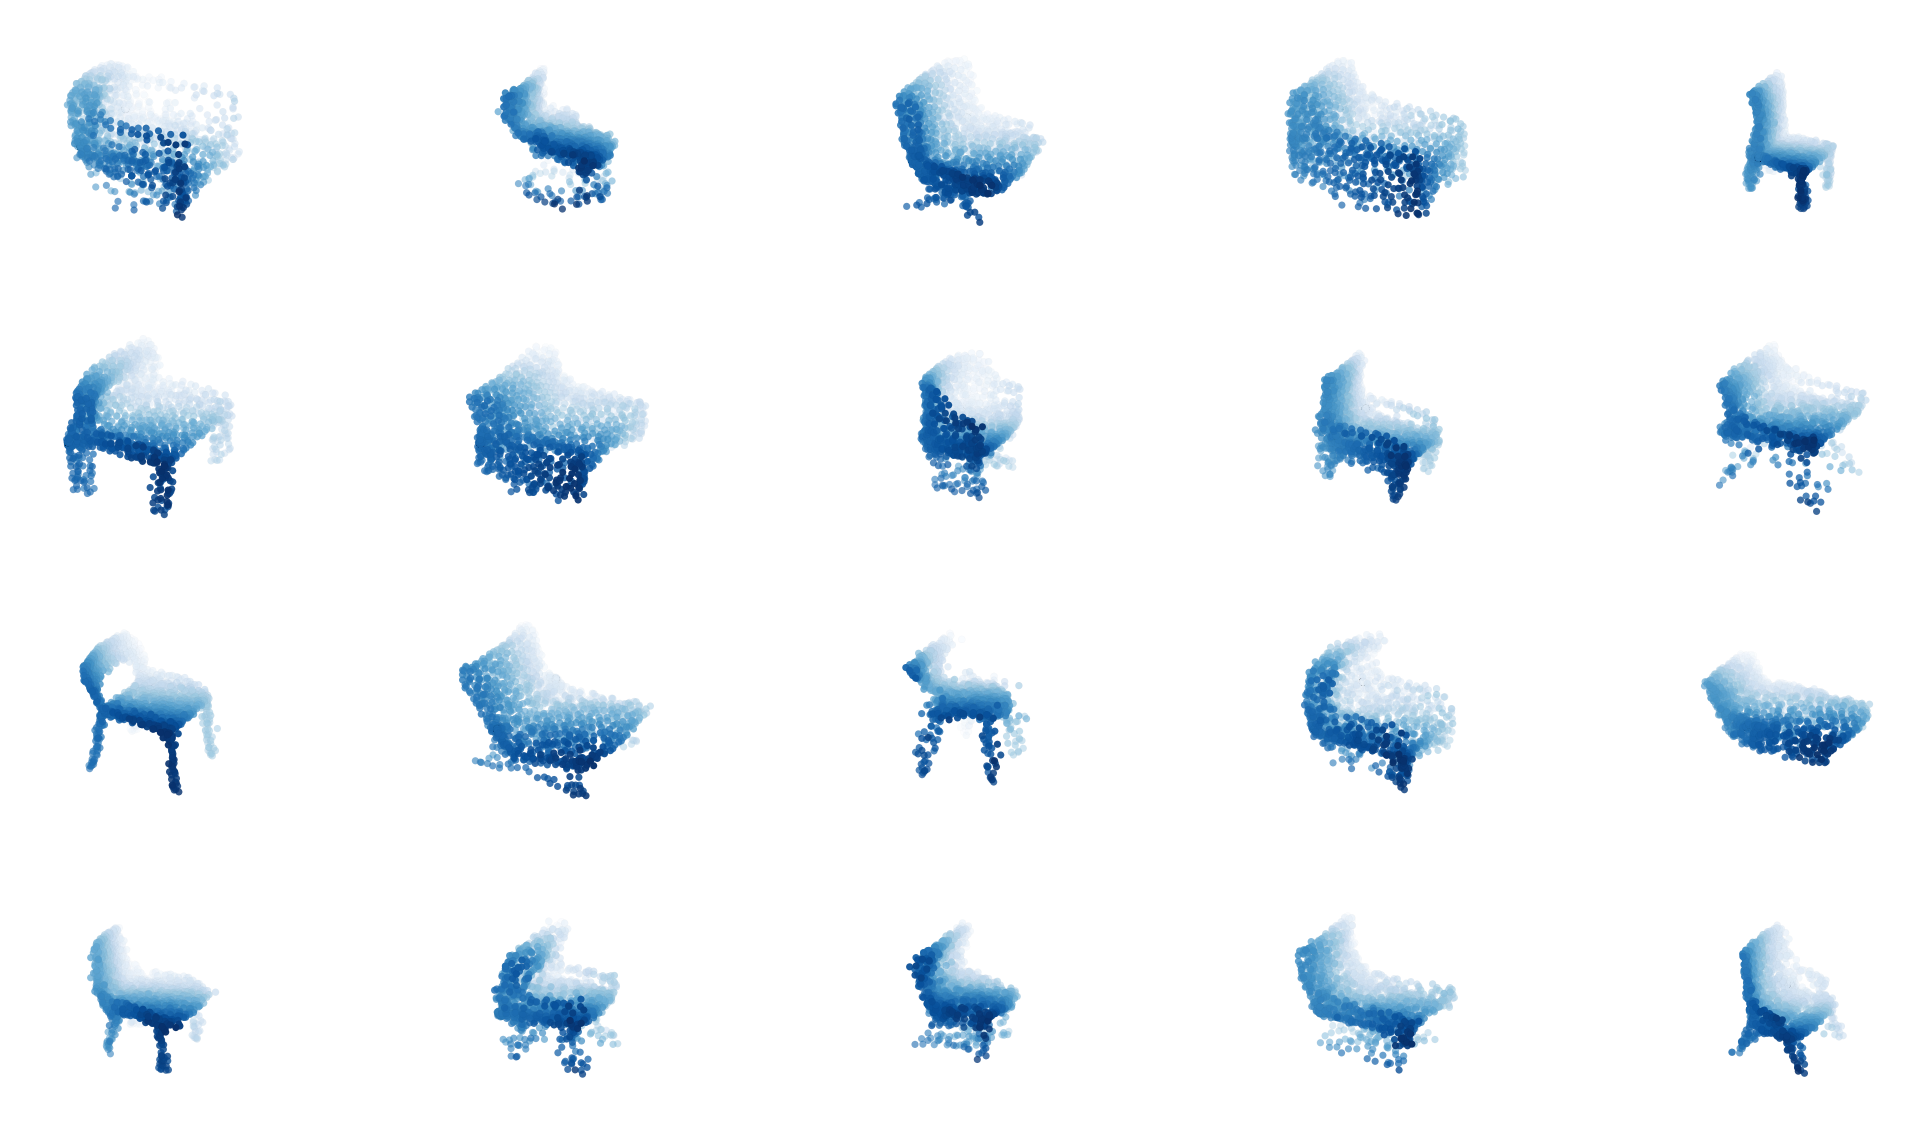

In [111]:
objs=[]
for i in range(20):
    noise= np.random.normal(0, 0.3, 2048)
    noise.astype(float)
    A=reconstruct_from_code(noise)
    objs.append(A)
plot_many_objects(4, 5, objs)

Correlation analysis for features

2021-08-23 04:36:19,453: DEBUG    Loaded backend module://ipykernel.pylab.backend_inline version unknown.
2021-08-23 04:37:00,739: DEBUG    locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f2ef1b25470>
2021-08-23 04:37:00,743: DEBUG    Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f2ef1b25470> on colorbar
2021-08-23 04:37:00,744: DEBUG    Setting pcolormesh


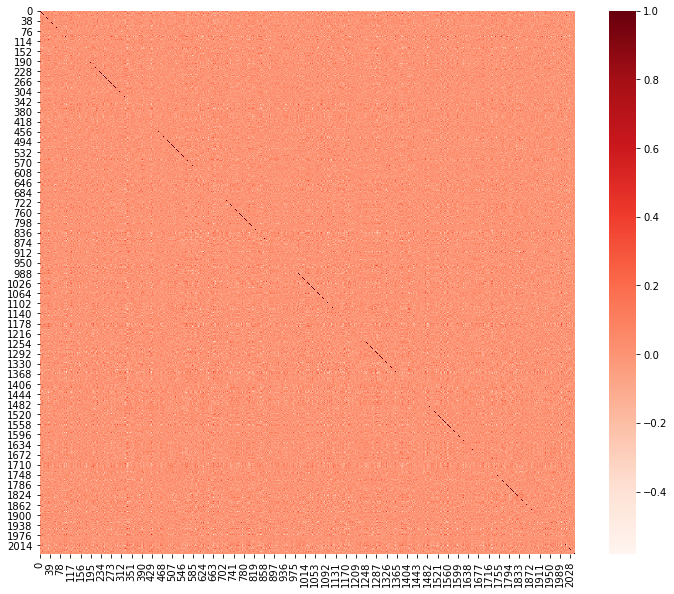

In [56]:
#importing libraries
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

#Loading the dataset
df = pd.DataFrame(chair_latent)
# df["MEDV"] = x.target
# X = df.drop("MEDV",1)   #Feature Matrix
# y = df["MEDV"]          #Target Variable
# df.head()

#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=False, cmap=plt.cm.Reds)
plt.show()

In [58]:
cor.shape

(2048, 2048)

2021-08-23 05:52:41,820: DEBUG    locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f2ef1ae2fd0>
2021-08-23 05:52:41,821: DEBUG    Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f2ef1ae2fd0> on colorbar
2021-08-23 05:52:41,822: DEBUG    Setting pcolormesh


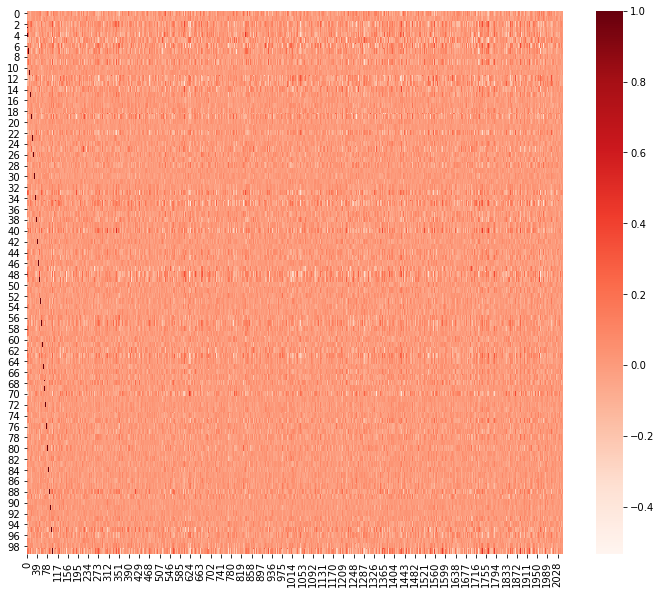

In [62]:
plt.figure(figsize=(12,10))
sns.heatmap(cor[:100], annot=False, cmap=plt.cm.Reds)
plt.show()

Agglomerative clustering for chairs

In [36]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [ ]:
model = AgglomerativeClustering(distance_threshold=None, n_clusters=20)
model = model.fit(chair_latent)

In [1]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(chair_latent)

NameError: name 'AgglomerativeClustering' is not defined

In [ ]:
agg_labels= model.labels_

Visualizations

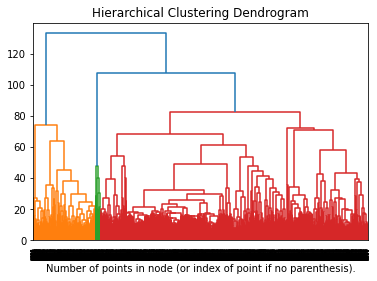

In [102]:
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=30)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

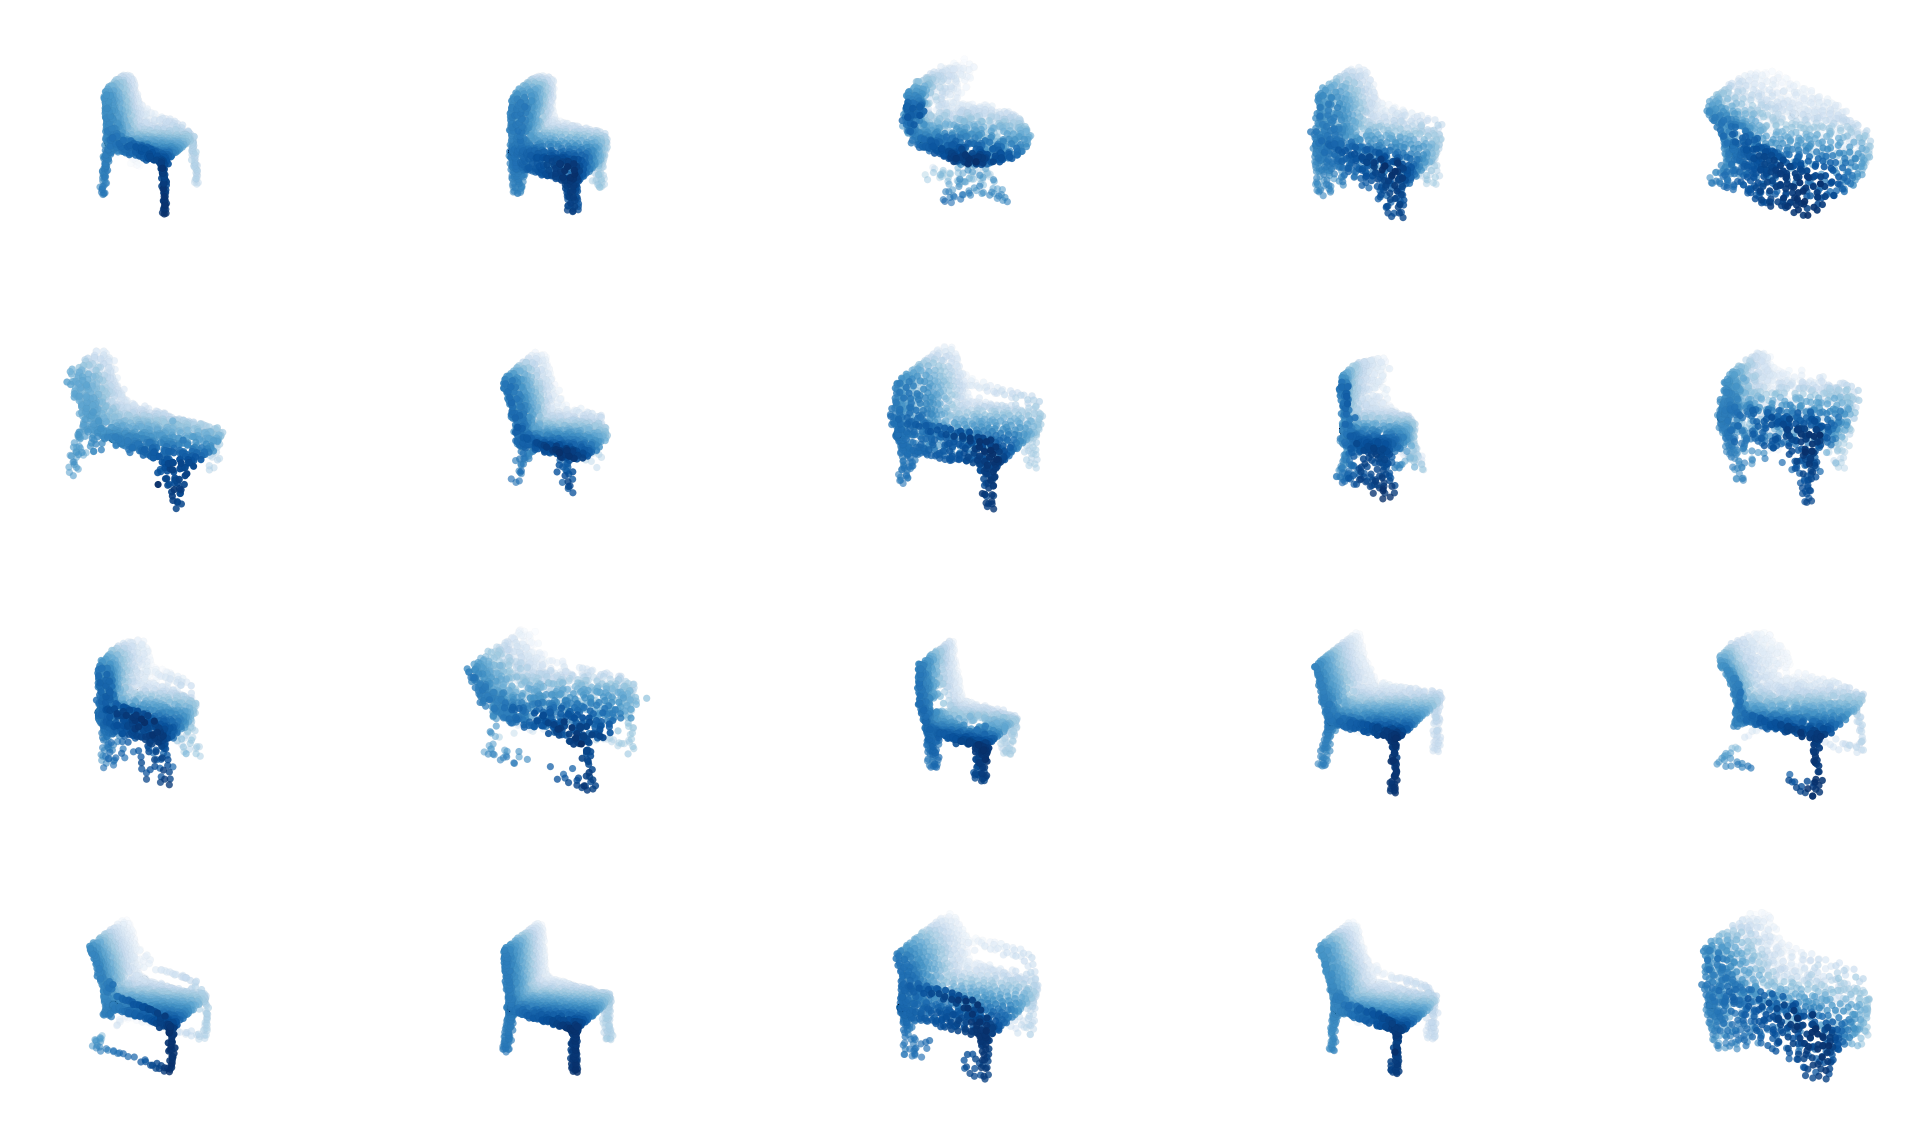

In [113]:
objs=[]
for i in range(20):
    for j in range(len(agg_labels)):
        if agg_labels[j]==i:
            A=reconstruct_from_code(chair_latent[j])
            objs.append(A)
plot_many_objects(4, 5, objs)

Latent-GAN

In [65]:
chair_latent= np.load('chair_latent.npy')

In [66]:
from typing import Tuple
import math
import torch
import torch.nn as nn
from typing import List
import numpy as np
import matplotlib.pyplot as plt

In [67]:
class Generator(nn.Module):

    def __init__(self, input_length: int):
        super(Generator, self).__init__()
        self.dense_layer = nn.Linear(int(input_length), int(input_length))
        self.dense_layer = nn.Linear(int(input_length), int(input_length))
        self.dense_layer = nn.Linear(int(input_length), int(input_length))
        self.activation = nn.Sigmoid()

    def forward(self, x):
        return self.activation(self.dense_layer(x))

In [68]:
class Discriminator(nn.Module):
    def __init__(self, input_length: int):
        super(Discriminator, self).__init__()
        self.dense = nn.Linear(int(input_length), int(input_length));
        self.dense = nn.Linear(int(input_length), int(input_length));
        self.dense = nn.Linear(int(input_length), int(input_length));
        self.dense = nn.Linear(int(input_length), 1);
        self.activation = nn.Sigmoid()

    def forward(self, x):
        return self.activation(self.dense(x))

In [69]:
def generate_chair_latent_batch(batch_number, batch_size, shuffle=False):
    true_data = torch.tensor(chair_latent[batch_size*batch_number:batch_size*(batch_number+1)])
    true_labels= torch.ones(batch_size).unsqueeze(1)
    return true_labels, true_data

In [76]:
def train(batch_size= 8, epochs= 500, from_epoch=0):
    input_length = 2048

    # Models
    generator = Generator(input_length)
    #generator.load_state_dict(torch.load('/home/jovyan/3d-AAE/test-results/aae/experiment/weights/chair_latent'+str(from_epoch)+'_G.pth'))
    discriminator = Discriminator(input_length)
    #discriminator.load_state_dict(torch.load('/home/jovyan/3d-AAE/test-results/aae/experiment/weights/chair_latent'+str(from_epoch)+'_D.pth'))

    # Optimizers
    generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)
    discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)

    # loss
    loss = nn.BCELoss()

    for i in range(from_epoch, from_epoch+epochs,1):
        for batch_number in range(int(5759/batch_size)):
            # zero the gradients on each iteration
            #generator_optimizer.zero_grad()

            # Create noisy input for generator
            # Need float type instead of int
            noise = torch.normal(mean=0, std=0.17, size=(batch_size, input_length)).float()
            generated_data = generator(noise)

            # Generate examples of even real data
            true_labels, true_data = generate_chair_latent_batch(batch_number, batch_size)
            true_labels = torch.tensor(true_labels).float().unsqueeze(1)
            true_data = torch.tensor(true_data).float()

            # Train the generator
            # We invert the labels here and don't train the discriminator because we want the generator
            # to make things the discriminator classifies as true.
            generator_discriminator_out = discriminator(generated_data)
            generator_loss = loss(generator_discriminator_out, torch.zeros(batch_size).unsqueeze(1))

            generator_loss.backward()
            generator_optimizer.step()

            # Train the discriminator on the true/generated data
            discriminator_optimizer.zero_grad()
            true_discriminator_out = discriminator(true_data)
            true_discriminator_loss = loss(true_discriminator_out, torch.ones(batch_size).unsqueeze(1))

            # add .detach() here think about this
            generator_discriminator_out = discriminator(generated_data.detach())
            generator_discriminator_loss = loss(generator_discriminator_out, torch.zeros(batch_size).unsqueeze(1))
            discriminator_loss = (true_discriminator_loss + generator_discriminator_loss) / 2
            discriminator_loss.backward()
            discriminator_optimizer.step()
            
        if i%10==0:
                print(i, generator_loss,true_discriminator_loss )
                torch.save(generator.state_dict(), '/home/jovyan/3d-AAE/test-results/aae/experiment/weights/chair_latent'+str(i)+'_G.pth')
                torch.save(discriminator.state_dict(), '/home/jovyan/3d-AAE/test-results/aae/experiment/weights/chair_latent'+str(i)+'_D.pth')
        
    return generator

In [77]:
if __name__ == "__main__":
    generator= train()

/home/jovyan/conda-envs/daiaAAEamaya2/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/jovyan/conda-envs/daiaAAEamaya2/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0 tensor(0.0009, grad_fn=<BinaryCrossEntropyBackward>) tensor(0.2075, grad_fn=<BinaryCrossEntropyBackward>)
10 tensor(5.2154e-08, grad_fn=<BinaryCrossEntropyBackward>) tensor(0.0079, grad_fn=<BinaryCrossEntropyBackward>)
20 tensor(1.4156e-07, grad_fn=<BinaryCrossEntropyBackward>) tensor(0.0006, grad_fn=<BinaryCrossEntropyBackward>)
30 tensor(0., grad_fn=<BinaryCrossEntropyBackward>) tensor(5.8212e-05, grad_fn=<BinaryCrossEntropyBackward>)
40 tensor(0., grad_fn=<BinaryCrossEntropyBackward>) tensor(7.7487e-06, grad_fn=<BinaryCrossEntropyBackward>)


KeyboardInterrupt: 

In [55]:
torch.save(generator.state_dict(), '/home/jovyan/3d-AAE/test-results/aae/experiment/weights/chair_latent10_G.pth')

In [78]:
generator2 = Generator(2048)
generator2.load_state_dict(torch.load('/home/jovyan/3d-AAE/test-results/aae/experiment/weights/chair_latent40_G.pth'))
generator2.eval()

Generator(
  (dense_layer): Linear(in_features=2048, out_features=2048, bias=True)
  (activation): Sigmoid()
)

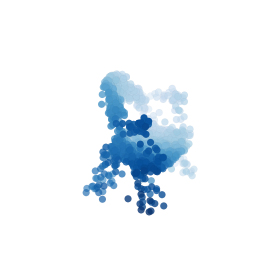

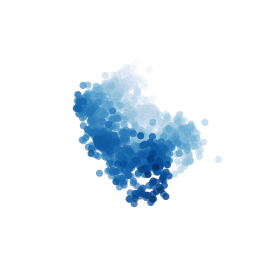

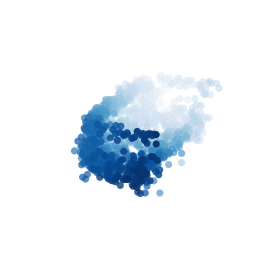

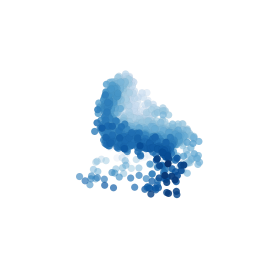

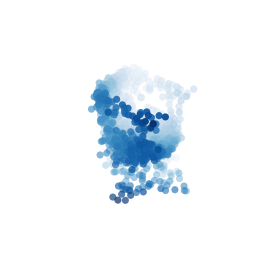

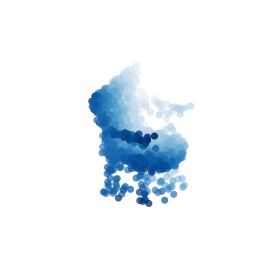

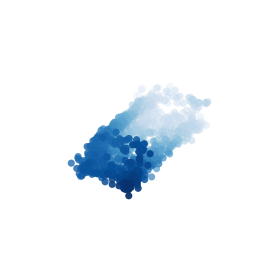

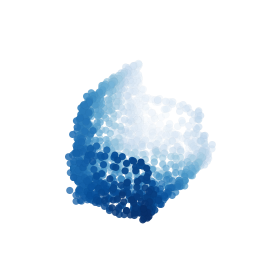

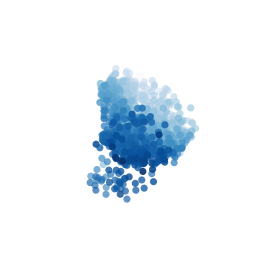

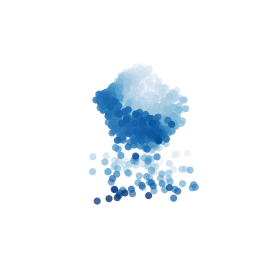

In [79]:
for k in range(10):
    noise =torch.normal(mean=0, std=0.2, size=(1, 2048)).float()
    generated_data = generator2(noise)
    B= reconstruct_from_code(generated_data[0].data.cpu().numpy())
    plot_pc_shaded(B)

In [122]:
def reconstruct_from_code(code):
    av=[]
    for i in range(50):
        av.append(code)
    av=np.reshape(av, (2048, 50)).T
    codes=torch.from_numpy(av).to("cuda")
    
    with torch.no_grad():
        X_rec = G(codes).data.cpu().numpy()
    #print(X_rec[30]==X_rec[10])
    return X_rec[0]

def plot_3d_point_cloud(x, y, z, show=True, show_axis=True, in_u_sphere=False,
                        marker='.', s=8, alpha=.8, figsize=(5, 5), elev=10,
                        azim=240, axis=None, title=None, *args, **kwargs):
    #plt.switch_backend('agg')
    
    if axis is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection='3d')
    else:
        ax = axis
        fig = axis

    if title is not None:
        plt.title(title)

    sc = ax.scatter(x, y, z, marker=marker, s=s, alpha=alpha, *args, **kwargs)
    ax.view_init(elev=elev, azim=azim)

    if in_u_sphere:
        ax.set_xlim3d(-0.5, 0.5)
        ax.set_ylim3d(-0.5, 0.5)
        ax.set_zlim3d(-0.5, 0.5)
    else:
        # Multiply with 0.7 to squeeze free-space.
        miv = 0.7 * np.min([np.min(x), np.min(y), np.min(z)])
        mav = 0.7 * np.max([np.max(x), np.max(y), np.max(z)])
        ax.set_xlim(miv, mav)
        ax.set_ylim(miv, mav)
        ax.set_zlim(miv, mav)
        plt.tight_layout()

    if not show_axis:
        plt.axis('off')

    if 'c' in kwargs:
        plt.colorbar(sc)

    if show:
        plt.show()

    return fig

In [40]:
chair_train= np.load('/home/daia/GPointNet-main/data/chair_train.npy')

In [41]:
chair_test= np.load('/home/daia/GPointNet-main/data/chair_test.npy')

In [43]:
chair_test.shape

(100, 2048, 3)

In [70]:
import gdown
url = 'https://drive.google.com/uc?id=1usCNOCptq6k6loF_oyAMsDYVLap01ZGZ'
output = '/home/daia/data/ShapeNet_Chair/03001627.zip'
gdown.download(url, output, quiet=False)

2021-08-22 10:40:46,345: DEBUG    Starting new HTTPS connection (1): drive.google.com:443
2021-08-22 10:40:47,931: DEBUG    https://drive.google.com:443 "GET /uc?id=1usCNOCptq6k6loF_oyAMsDYVLap01ZGZ HTTP/1.1" 200 None
2021-08-22 10:40:47,997: DEBUG    Starting new HTTPS connection (1): docs.google.com:443
2021-08-22 10:40:48,530: DEBUG    https://docs.google.com:443 "GET /uc?export=download&confirm=vo8J&id=1usCNOCptq6k6loF_oyAMsDYVLap01ZGZ HTTP/1.1" 200 None
2021-08-22 10:40:48,947: DEBUG    https://docs.google.com:443 "GET /uc?export=download&confirm=jps4&id=1usCNOCptq6k6loF_oyAMsDYVLap01ZGZ HTTP/1.1" 302 None
2021-08-22 10:40:48,955: DEBUG    Starting new HTTPS connection (1): doc-00-3c-docs.googleusercontent.com:443
2021-08-22 10:40:49,347: DEBUG    https://doc-00-3c-docs.googleusercontent.com:443 "GET /docs/securesc/te502j4mngdnibif106hto8kn4q87d7s/emcg9rlv836d84h9hnu06vrhtvk0d5r9/1629628800000/16549612992974680279/16759326357461533362Z/1usCNOCptq6k6loF_oyAMsDYVLap01ZGZ?e=download 

'/home/daia/data/ShapeNet_Chair/03001627.zip'

In [ ]:
https://drive.google.com/file/d/1wpCuiVyNWcmfmSW3YgPbJp1AM-RWht1g/view?usp=sharing
    https://drive.google.com/file/d/1VBlqbUnMlnwvq3NCwuUiElx__3Z23ABg/view?usp=sharing

In [ ]:
https://drive.google.com/file/d/1usCNOCptq6k6loF_oyAMsDYVLap01ZGZ/view?usp=sharing